In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

In [25]:
# 1. Load Data
def load_data(path):
    df = pd.read_csv(path, delimiter=';')
    return df

# Statiscs about the Dataset

In [26]:
# 2. Explore Data
df = load_data('personen_datensatz.csv')
def explore_data(df):
    print("\nDataset Count:\n", df.count())
    print("\nMissing Values Count:\n", df.isnull().sum())
    print("\nDuplicated Values Count:\n", df.duplicated().sum())
    print("\nData Types:\n", df.dtypes)
    print("\nDataset Description:\n", df.describe())
    print("\nNon-Numerical Columns Information:\n", df.select_dtypes(include=['object']).describe())
explore_data(df)


Dataset Count:
 Person Nr.      1000
Alter            982
Groesse (cm)     985
Gewicht (kg)    1000
Abschluss        862
Augenfarbe       788
Einkommen        876
dtype: int64

Missing Values Count:
 Person Nr.        0
Alter            18
Groesse (cm)     15
Gewicht (kg)      0
Abschluss       138
Augenfarbe      212
Einkommen       124
dtype: int64

Duplicated Values Count:
 0

Data Types:
 Person Nr.        int64
Alter           float64
Groesse (cm)    float64
Gewicht (kg)      int64
Abschluss        object
Augenfarbe       object
Einkommen        object
dtype: object

Dataset Description:
         Person Nr.       Alter  Groesse (cm)  Gewicht (kg)
count  1000.000000  982.000000    985.000000   1000.000000
mean    500.500000   58.990835    179.894416     89.897000
std     288.819436   23.834182     18.054035     18.007461
min       1.000000   18.000000    150.000000     60.000000
25%     250.750000   39.000000    164.000000     74.000000
50%     500.500000   59.000000    179.000000

# Visualaisation

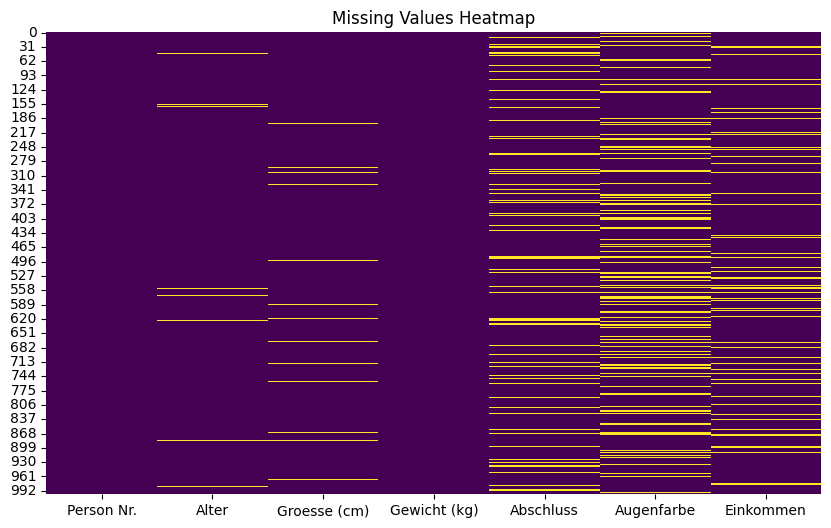

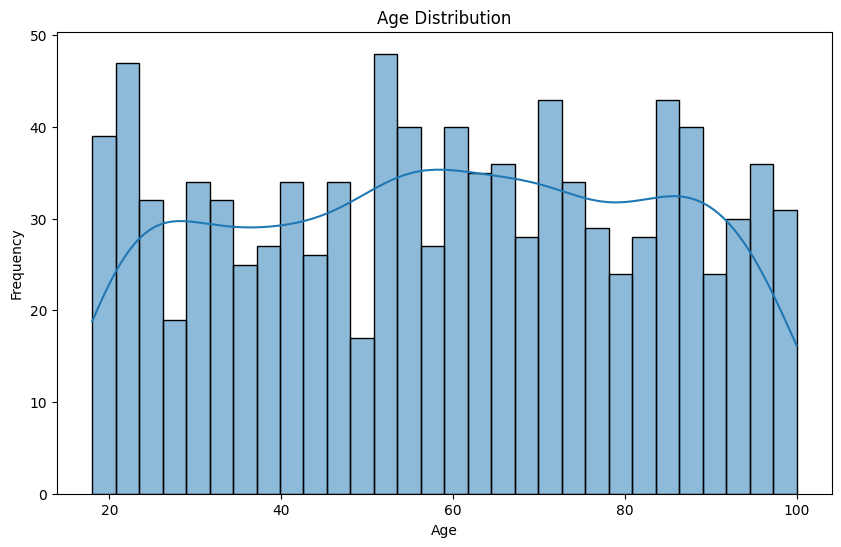

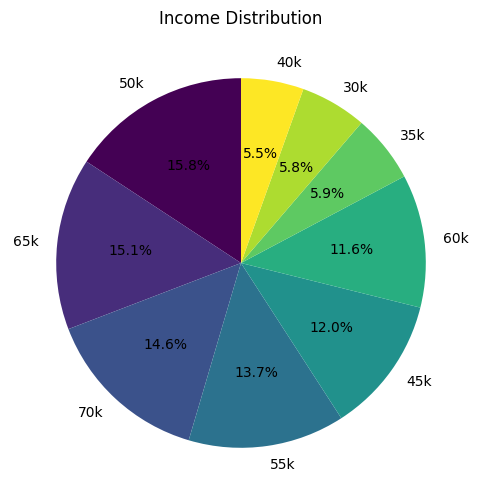

In [27]:
# 3. Visualize Data
def visualize_data(df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(df['Alter'], bins=30, kde=True)
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 6))
    df['Einkommen'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
    plt.title('Income Distribution')
    plt.ylabel('')
    plt.show()
visualize_data(df)


In [29]:
# check the uniqe values of each categorical feature
categorical_columns = ['Abschluss', 'Augenfarbe', 'Einkommen']
for column in categorical_columns:
    unique_values = df[column].unique()
    print(f"Unique values in '{column}': {unique_values}")

Unique values in 'Abschluss': ['M.Eng.' 'B.A.' 'B.Sc.' nan 'M.Sc.' 'M.A.' 'B.Eng.']
Unique values in 'Augenfarbe': ['blau' 'schwarz' nan 'gruen' 'braun']
Unique values in 'Einkommen': ['65k' '30k' '60k' '50k' nan '55k' '45k' '40k' '35k' '70k']


# Data Preprocessing

## Data Transformation

In [33]:
def preprocess_data(dataset):
    # Drop unnecessary columns
    if 'Person Nr.' in dataset.columns:
        dataset = df.drop(columns=['Person Nr.'])

    # Impute missing values
    num_cols = dataset.select_dtypes(include=[np.number]).columns
    cat_cols = [col for col in categorical_columns if col in dataset.columns]

    num_imputer = SimpleImputer(strategy='mean')
    dataset[num_cols] = num_imputer.fit_transform(dataset[num_cols])

    cat_imputer = SimpleImputer(strategy='most_frequent')
    dataset[cat_cols] = cat_imputer.fit_transform(dataset[cat_cols])

    # Ordinal encode the target column 'Einkommen'
    ordinal_encoder = OrdinalEncoder()
    dataset[['Einkommen']] = ordinal_encoder.fit_transform(dataset[['Einkommen']])

    # One-hot encode the other categorical columns (excluding 'Einkommen')
    feature_cat_cols = [col for col in cat_cols if col != 'Einkommen']
    if feature_cat_cols:
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        encoded = encoder.fit_transform(dataset[feature_cat_cols])
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(feature_cat_cols), index=dataset.index)
        # Concatenate encoded columns and drop originals
        dataset = pd.concat([dataset.drop(columns=feature_cat_cols), encoded_df], axis=1)

    # Feature scaling
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns, index=dataset.index)

    # Separate features and target
    X = scaled_data.drop(columns=['Einkommen'])
    y = scaled_data['Einkommen'].astype(int)  # Use ordinal-encoded target as integer

    return X, y


X, y = preprocess_data(df)
X.head()

,Alter,Groesse (cm),Gewicht (kg),Abschluss_B.Eng.,Abschluss_B.Sc.,Abschluss_M.A.,Abschluss_M.Eng.,Abschluss_M.Sc.,Augenfarbe_braun,Augenfarbe_gruen,Augenfarbe_schwarz
0,0.658537,0.333333,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.085366,0.783333,0.783333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.341463,0.716667,0.716667,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.500000,0.166667,0.166667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.390244,0.800000,0.800000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [35]:
X.shape
# Features (X) and

(1000, 11)

In [34]:
# 5. Feature Selection
def feature_selection(scaled_data):
    # Remove constant features
    constant_features = [col for col in scaled_data.columns if scaled_data[col].nunique() == 1]
    features = scaled_data.drop(columns=constant_features)

    # Remove highly correlated features
    corr_matrix = features.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
    features = features.drop(columns=to_drop)

    return features
features = feature_selection(X)
features.head()

,Alter,Groesse (cm),Abschluss_B.Eng.,Abschluss_B.Sc.,Abschluss_M.A.,Abschluss_M.Eng.,Abschluss_M.Sc.,Augenfarbe_braun,Augenfarbe_gruen,Augenfarbe_schwarz
0,0.658537,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.085366,0.783333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.341463,0.716667,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.500000,0.166667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.390244,0.800000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [37]:
features.shape
features.head()


,Alter,Groesse (cm),Abschluss_B.Eng.,Abschluss_B.Sc.,Abschluss_M.A.,Abschluss_M.Eng.,Abschluss_M.Sc.,Augenfarbe_braun,Augenfarbe_gruen,Augenfarbe_schwarz
0,0.658537,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.085366,0.783333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.341463,0.716667,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.500000,0.166667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.390244,0.800000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [38]:
# 6. Split Data
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print("Training Features Shape:", X_train.shape)
    print("Testing Features Shape:", X_test.shape)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = split_data(features, y)

Training Features Shape: (800, 10)
Testing Features Shape: (200, 10)


In [39]:
# 7. Train Model
def train_model(X_train, y_train, X_test, y_test):
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    return clf
clf = train_model(X_train, y_train, X_test, y_test)


Accuracy: 0.765


In [40]:
# 9. Hyperparameter Tuning
def hyperparameter_tuning(X_train, y_train):
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_search = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=42),
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Accuracy:", grid_search.best_score_)
    return grid_search
grid_search = hyperparameter_tuning(X_train, y_train)

Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.8537500000000001
